In [1]:
"""
 Import statements
"""

import hipopy.hipopy # <--- Package for reading in the hipo files
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import ROOT

# Set LaTeX font for Matplotlib
rc('text', usetex=True)


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-eeiqdwli because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to JupyROOT 6.22/06


---

Loading the hipo file using `hipopy`


In [2]:


filename = "/cache/clas12/rg-a/production/recon/fall2018/torus-1/pass1/v1/dst/train/nSidis/nSidis_005032.hipo"


hipo_file = hipopy.hipopy.open(filename,mode='r')


# Read the REC::Particle and REC::Calorimeter banks
hipo_file.readBank('REC::Particle')
hipo_file.readBank('REC::Calorimeter')

# Showing the data types inside each bank
print("REC::Particle data","\n"+100*"=")
display(hipo_file.getNamesAndTypes('REC::Particle'))
print(100*"=","\nREC::Calorimeter data","\n"+100*"=")
display(hipo_file.getNamesAndTypes('REC::Calorimeter'))

REC::Particle data 


{'pid': 'I',
 'px': 'F',
 'py': 'F',
 'pz': 'F',
 'vx': 'F',
 'vy': 'F',
 'vz': 'F',
 'vt': 'F',
 'charge': 'B',
 'beta': 'F',
 'chi2pid': 'F',
 'status': 'S'}

REC::Calorimeter data 


{'index': 'S',
 'pindex': 'S',
 'detector': 'B',
 'sector': 'B',
 'layer': 'B',
 'energy': 'F',
 'time': 'F',
 'path': 'F',
 'chi2': 'F',
 'x': 'F',
 'y': 'F',
 'z': 'F',
 'hx': 'F',
 'hy': 'F',
 'hz': 'F',
 'lu': 'F',
 'lv': 'F',
 'lw': 'F',
 'du': 'F',
 'dv': 'F',
 'dw': 'F',
 'm2u': 'F',
 'm2v': 'F',
 'm2w': 'F',
 'm3u': 'F',
 'm3v': 'F',
 'm3w': 'F',
 'status': 'S'}

compression type = 0 data length = 157529


---
Here, we set the maximum number of events it analyze. This way we do not wait too long for the code to finish processing

In [15]:
Nevents = 3000

---
We define some functions for calculating the event variables, along with a few constants

In [16]:
Mp = 0.938272 # proton mass, GeV
Me = 0.000511 # electron mass, GeV
beamE = 10.6041 # electron beam energy for Fall2018 RG-A, GeV

vec_eIn = ROOT.TLorentzVector(0,0,np.sqrt(beamE**2-Me**2),beamE) # Px, Py, Pz, E for initial electron
vec_pIn = ROOT.TLorentzVector(0,0,0,Mp) # Px, Py, Pz, E for initial (at rest) proton

# Formulas for calculating the event variables. All are functions of ROOT TLorentzVector objects
# See (https://root.cern.ch/doc/master/classTLorentzVector.html)

def calc_Q2(kf):
    return -(vec_eIn-kf).M2()


def calc_x(kf):
    _Q2 = calc_Q2(kf)
    _q  = vec_eIn-kf
    return _Q2/(2*vec_pIn*_q)


def calc_W(kf):
    _q = vec_eIn-kf
    return (_q+vec_pIn).M()

def calc_y(kf):
    _q = vec_eIn-kf
    return (_q*vec_pIn)/(vec_eIn*vec_pIn)

---
Below we will define some lists containing key event/particle information that we will plot later. 



We then write the event loop...

1. We read the momentums and particle ids from `REC::Particle` as arrays (each element of the array correspond to the value for that particle).

2. We make sure that at least one electron is found. If not, we skip the event. 

3. Then, we find the electron in the event with the highest energy, ensuring it has at least 2.5 GeV (skipping otherwise). We label this as the scattered electron (good for now)

4. Afterwards, we apply a basic PID enhancement cut on the scattered electron. We will make sure that it deposits at least 100 MeV in the Preshower Calorimeter. If it does not, we will toss the event and move onto the next one.

5. If the electron passes our detector cut, we will append the particle and event information to our lists.

In [17]:
ele_P_arr = []
ele_Theta_arr = []
ele_Phi_arr = []

# See (http://www.physics.smu.edu/olness/ftp/misc2/cteq/2015/gaskell_dis_part1.pdf) for information/formulas
x_arr = [] # Momentum fraction of struck quark
Q2_arr = [] # Hard scale/resolution of process
W_arr = [] # Invariant mass of the final hadronic system
y_arr = [] # Inelasticity

for i,_ in enumerate(hipo_file):
    
    # Exit loop after "Nevents" have been analyzed
    if(i>Nevents):
        break
    
    
    
    # Step 1. Read the momentums and particle ids from REC::Particle as arrays
    px = np.array(hipo_file.getFloats("REC::Particle", "px")) # Use getFloats because the "px" datatype is "F" , see first cell output after imports
    py = np.array(hipo_file.getFloats("REC::Particle", "py"))
    pz = np.array(hipo_file.getFloats("REC::Particle", "pz"))
    pid = np.array(hipo_file.getInts("REC::Particle", "pid"))    
    
    
    
    # Step 2. Find indices of pid==11 (electron) particles
    indices_of_electrons = np.where(pid==11)[0]
    
    if indices_of_electrons.size == 0:
        continue # No electrons in event
    
    
    
    # Step 3. Find the electron with the largest energy, toss it if the energy is less than 2.5 GeV
    max_ele_energy = -1
    idx_ele = -1
    for index_of_electron in indices_of_electrons:
        px_ele = px[index_of_electron]
        py_ele = py[index_of_electron]
        pz_ele = pz[index_of_electron]
        p_ele = np.sqrt(px_ele**2+py_ele**2+pz_ele**2)
        E_ele = np.sqrt(p_ele**2+Me**2)
        
        if(E_ele > max_ele_energy):
            # This electron has a higher energy
            max_ele_energy = E_ele
            idx_ele = index_of_electron # Set this electron as the scattered
    
    if(max_ele_energy<2.5):
        continue # Highest energy electron has too low of an energy
    
    
    
    # Step 4. Apply PCAL Edep > 0.1 GeV cut on the scattered electron
    # --> pindex corresponds to the index of the particle in REC::Particle responsible for the calorimeter signal
    # --> There are 3 calorimeters for CLAS12 (PCAL, ECIN, ECOUT) which have a different layer id (1,4,7)
    # --> Use the same pindex as the scattered electron to find its PCAL energy dep
    
    
    
    cal_pindex = np.array(hipo_file.getShorts("REC::Calorimeter","pindex"))
    cal_layer =  np.array(hipo_file.getBytes("REC::Calorimeter","layer"))
    cal_energy = np.array(hipo_file.getFloats("REC::Calorimeter","energy"))
    
    # Find PCAL energy deposits for the scattered electron
    scattered_cal_index = np.where((cal_pindex == idx_ele) & (cal_layer == 1))[0]
    if len(scattered_cal_index) == 0:
        continue  # Scattered electron doesn't have PCAL energy deposit

    scattered_cal_energy = cal_energy[scattered_cal_index]
    if scattered_cal_energy < 0.1:
        continue  # PCAL energy deposit for scattered electron is less than 0.1 GeV

        
        
    # Step 5. Calculate and append kinematics
    kf = ROOT.TLorentzVector()
    kf.SetXYZM(px[idx_ele],
               py[idx_ele],
               pz[idx_ele],
               Me) # set scattered electron TLorentzVector
    
    ele_P = kf.P()
    ele_Theta = kf.Theta()
    ele_Phi = kf.Phi()

    ele_P_arr.append(ele_P)
    ele_Theta_arr.append(ele_Theta*180/np.pi)
    ele_Phi_arr.append(ele_Phi*180/np.pi)

    # Calculate and append kinematic variables
    x = calc_x(kf)
    Q2 = calc_Q2(kf)
    W = calc_W(kf)
    y = calc_y(kf)

    x_arr.append(x)
    Q2_arr.append(Q2)
    W_arr.append(W)
    y_arr.append(y)

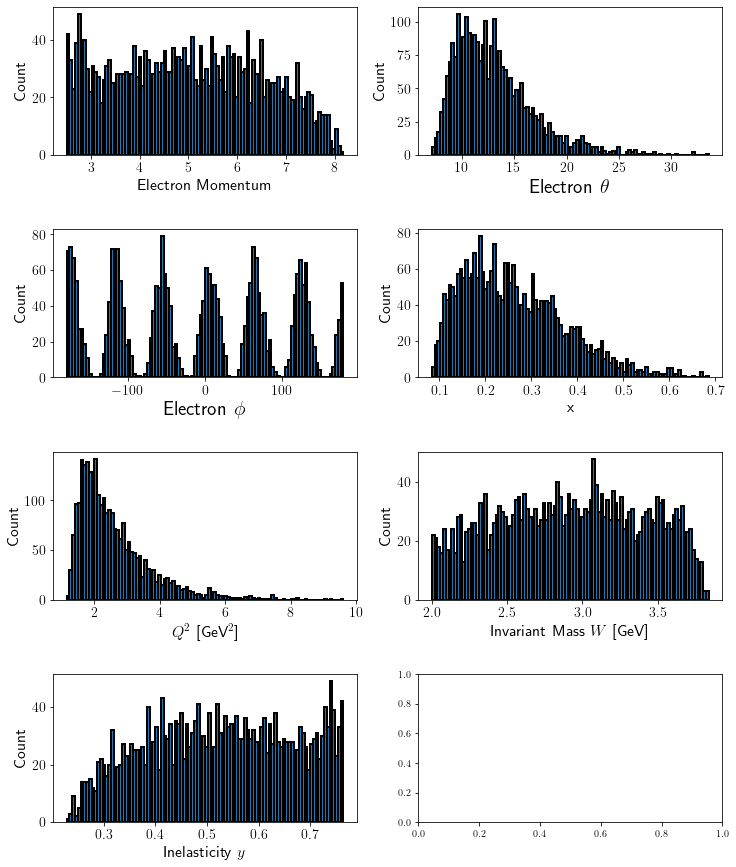

In [18]:
nbins = 100

# Create a grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 15))

# Adjust vertical spacing
fig.subplots_adjust(hspace=0.5)

# Plot ele_P_arr histogram
axs[0, 0].hist(ele_P_arr, bins=nbins, edgecolor='black', linewidth=2)
axs[0, 0].set_xlabel('Electron Momentum', fontsize=16)
axs[0, 0].set_ylabel('Count', fontsize=16)
axs[0, 0].tick_params(axis='both', which='major', labelsize=14)

# Plot ele_Theta_arr histogram
axs[0, 1].hist(ele_Theta_arr, bins=nbins, edgecolor='black', linewidth=2)
axs[0, 1].set_xlabel(r'Electron $\theta$', fontsize=20)
axs[0, 1].set_ylabel('Count', fontsize=16)
axs[0, 1].tick_params(axis='both', which='major', labelsize=14)

# Plot ele_Phi_arr histogram
axs[1, 0].hist(ele_Phi_arr, bins=nbins, edgecolor='black', linewidth=2)
axs[1, 0].set_xlabel(r'Electron $\phi$', fontsize=20)
axs[1, 0].set_ylabel('Count', fontsize=16)
axs[1, 0].tick_params(axis='both', which='major', labelsize=14)

# Plot x_arr histogram
axs[1, 1].hist(x_arr, bins=nbins, edgecolor='black', linewidth=2)
axs[1, 1].set_xlabel('x', fontsize=16)
axs[1, 1].set_ylabel('Count', fontsize=16)
axs[1, 1].tick_params(axis='both', which='major', labelsize=14)

# Plot Q2_arr histogram
axs[2, 0].hist(Q2_arr, bins=nbins, edgecolor='black', linewidth=2)
axs[2, 0].set_xlabel('$Q^2$ [GeV$^{2}$]', fontsize=16)
axs[2, 0].set_ylabel('Count', fontsize=16)
axs[2, 0].tick_params(axis='both', which='major', labelsize=14)

# Plot W_arr histogram
axs[2, 1].hist(W_arr, bins=nbins, edgecolor='black', linewidth=2)
axs[2, 1].set_xlabel('Invariant Mass $W$ [GeV]', fontsize=16)
axs[2, 1].set_ylabel('Count', fontsize=16)
axs[2, 1].tick_params(axis='both', which='major', labelsize=14)

# Plot y_arr histogram
axs[3, 0].hist(y_arr, bins=nbins, edgecolor='black', linewidth=2)
axs[3, 0].set_xlabel('Inelasticity $y$', fontsize=16)
axs[3, 0].set_ylabel('Count', fontsize=16)
axs[3, 0].tick_params(axis='both', which='major', labelsize=14)

# Show the plot
plt.show()